# Dataset
- Dataset: Garis Kemiskinan Indonesia
- Deskripsi: Dataset ini memuat data garis kemiskinan yang diklasifikasikan berdasarkan provinsi, jenis pengeluaran, wilayah (perkotaan atau perdesaan), tahun, dan periode waktu.
- Tujuan:  mengidentifikasi segmen atau kluster yang mencerminkan karakteristik kesejahteraan pekerja berdasarkan variabel-variabel yang tersedia dalam dataset.

# Import Library Yang Dibutuhkan

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Load Dataset

In [59]:
df = pd.read_csv("Dataset_inisiasi.csv")
df.head()

,provinsi,jenis,daerah,tahun,periode,gk
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0


# Exploratory Data Analysis (EDA)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  5460 non-null   object 
 1   jenis     5460 non-null   object 
 2   daerah    5460 non-null   object 
 3   tahun     5460 non-null   int64  
 4   periode   5460 non-null   object 
 5   gk        5261 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 256.1+ KB


In [61]:
df.describe()

,tahun,gk
count,5460.000000,5261.000000
mean,2018.115385,303904.185516
std,2.577159,158176.024903
min,2013.000000,48561.000000
25%,2016.000000,144674.000000
50%,2018.000000,313294.000000
75%,2020.000000,410188.000000
max,2022.000000,872843.000000


In [62]:
missing_values = df.isnull().sum()
missing_values

,0
provinsi,0
jenis,0
daerah,0
tahun,0
periode,0
gk,199


## Visualisasi Distribusi Data

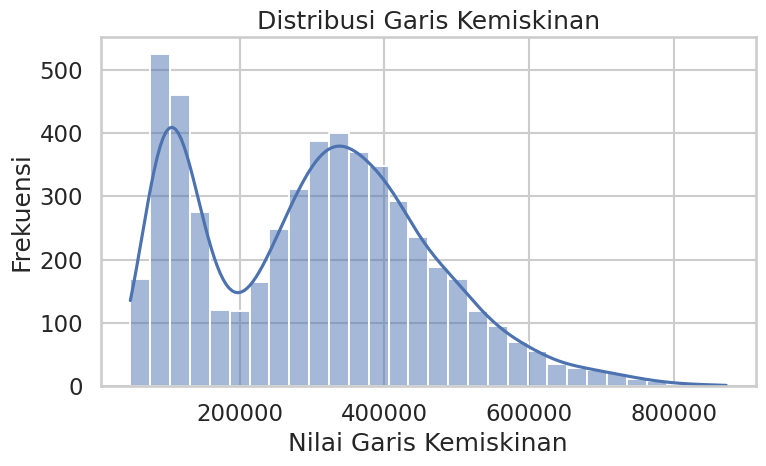

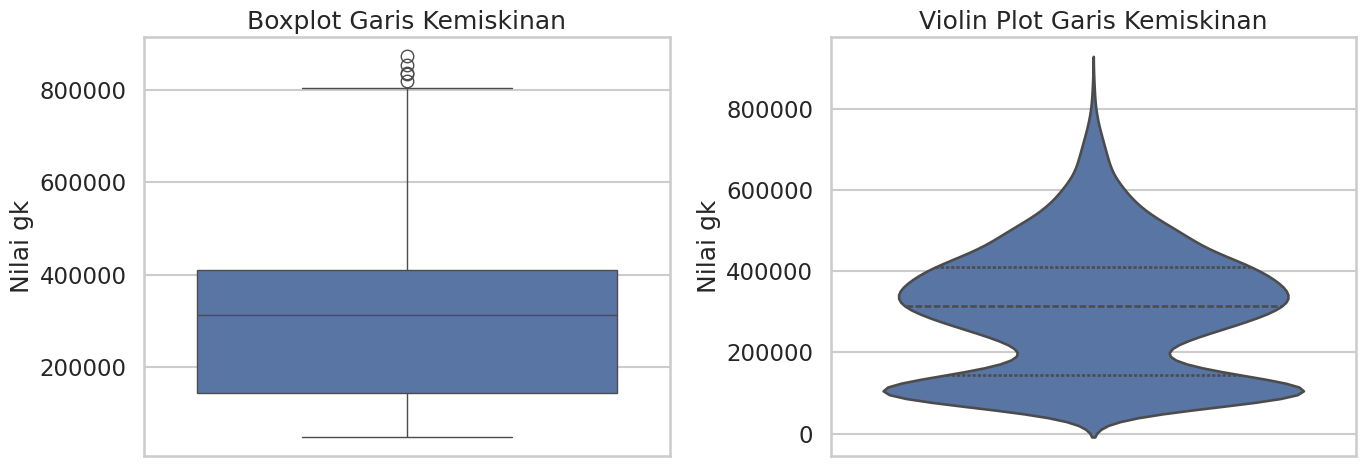

In [ ]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8,5))
sns.histplot(df['gk'], bins=30, kde=True)
plt.title("Distribusi Garis Kemiskinan")
plt.xlabel("Nilai Garis Kemiskinan")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.boxplot(y=df['gk'], ax=axes[0])
axes[0].set_title("Boxplot Garis Kemiskinan")
axes[0].set_ylabel("Nilai gk")

sns.violinplot(y=df['gk'], inner="quartile", ax=axes[1])
axes[1].set_title("Violin Plot Garis Kemiskinan")
axes[1].set_ylabel("Nilai gk")

plt.tight_layout()
plt.show()

<ipython-input-64-30018de88fa6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


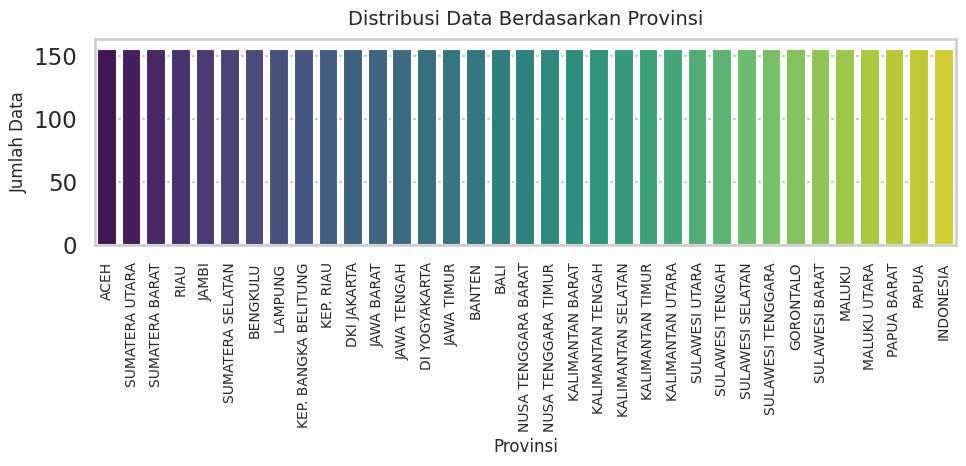

In [64]:
plt.figure(figsize=(10, 5))

sns.countplot(
    x='provinsi',
    data=df,
    palette='viridis'
)

plt.title("Distribusi Data Berdasarkan Provinsi", fontsize=14, pad=10)
plt.xlabel("Provinsi", fontsize=12)
plt.ylabel("Jumlah Data", fontsize=12)
plt.xticks(rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

### Penjelasan

- **Histogram**: Menampilkan distribusi data "Nilai gk" untuk melihat pola distribusi, apakah normal, miring (skewed), atau mengandung nilai ekstrem yang dapat dianggap sebagai outlier.  
- **Boxplot**: Menggambarkan ringkasan statistik data (median, kuartil, dan rentang interkuartil) serta membantu mengidentifikasi adanya outlier berdasarkan aturan IQR (nilai di luar 1.5 kali IQR).  
- **Violin Plot**: Menggabungkan informasi distribusi seperti histogram dengan kepadatan data, memberikan gambaran lebih halus tentang pola distribusi dan potensi nilai ekstrem.
- **Count Plot**: Menunjukkan distribusi data kategorikal untuk mengetahui apakah terdapat kategori yang sangat dominan.

# Data preprocessing

Pakai imputasi untuk menangani missing values

In [65]:
imputer = SimpleImputer(strategy='mean')
df['gk'] = imputer.fit_transform(df[['gk']])

Karena kita pakai K-Means, kita perlu mengubah data kategorikal menjadi data numerik.

In [66]:
label_encoder = LabelEncoder()
df['encoded_jenis'] = label_encoder.fit_transform(df['jenis'])
df['encoded_daerah'] = label_encoder.fit_transform(df['daerah'])

Scaling diperlukan untuk memastikan perbedaan skala antar fitur tidak memengaruhi hasil clustering.

In [67]:
scaler = StandardScaler()
df['scaled_gk'] = scaler.fit_transform(df[['gk']])

Kita pakai `scaled_gk`, `encoded_jenis`, `encoded_daerah` sebaga features

In [68]:
features = ['scaled_gk', 'encoded_jenis', 'encoded_daerah']
X = df[features]

# Pembangunan Model Clustering

**Penentuan Jumlah Cluster Optimal**

Saya menggunakan metode Elbow dan Silhouette Score untuk menentukan jumlah cluster yang optimal.

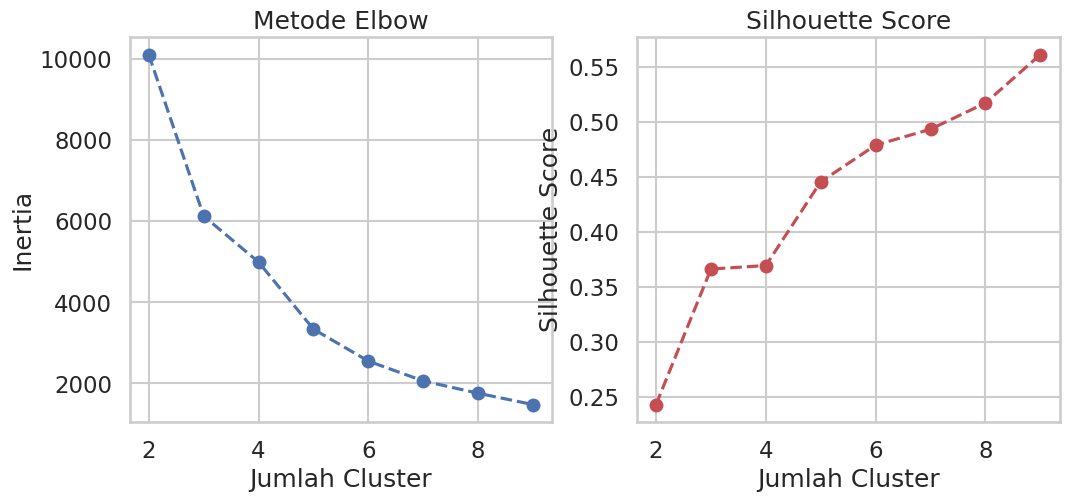

Jumlah cluster optimal berdasarkan Silhouette Score: 9


In [69]:
silhouette_scores = []
elbow_scores = []
K_range = range(2, 10)  # Mencoba jumlah cluster dari 2 - 9

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    elbow_scores.append(kmeans.inertia_)

# Visualisasi metode Elbow
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, elbow_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia")
plt.title("Metode Elbow")

# Visualisasi Silhouette Score
plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

# Menentukan jumlah cluster optimal
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print("Jumlah cluster optimal berdasarkan Silhouette Score:", optimal_k)

## Penjelasan

- **Metode Elbow**: Menggunakan inertia (jumlah kuadrat jarak dalam cluster) untuk mengevaluasi varians. Titik “elbow” mencerminkan saat penurunan inertia mulai melambat, menandakan jumlah cluster yang optimal.  
- **Silhouette Score**: Mengukur kualitas pengelompokan dengan mengevaluasi kedekatan data dalam cluster dan pemisahan antar cluster. Nilai di atas 0,55 (atau target lebih tinggi) menunjukkan clustering yang baik.

# Evaluasi Model Clustering

In [70]:
# Melatih model dengan jumlah cluster optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Evaluasi akhir menggunakan Silhouette Score
final_score = silhouette_score(X, df['cluster'])
print("Silhouette Score akhir:", final_score)

Silhouette Score akhir: 0.5609656847756213


# Feature Selection

Untuk meningkatkan performa clustering, saya menerapkan *feature selection* guna memilih fitur yang paling relevan. Salah satu metode yang digunakan adalah **SelectKBest** untuk memilih fitur terbaik berdasarkan skor statistik. Berikut implementasinya:

### Catatan
- Data awal merupakan kombinasi fitur numerik dan hasil *encoding*. Oleh karena itu, *feature selection* harus dilakukan dengan mempertimbangkan konteks data.
- Jika jumlah fitur banyak, teknik ini dapat mengurangi dimensi, meningkatkan efisiensi, dan mencegah overfitting.
- Untuk mengevaluasi dampaknya, bandingkan **Silhouette Score** sebelum dan sesudah *feature selection* untuk memastikan kualitas clustering tetap terjaga atau meningkat.

In [71]:
# Target 'gk_scaled' sebagai variabel dependen, pilih fitur yang berkorelasi tertinggi
selector = SelectKBest(score_func=f_classif, k=3)
X_new = selector.fit_transform(X, df['scaled_gk'])
selected_features = selector.get_support(indices=True)
print("Indeks fitur terpilih:", selected_features)

# Bandingkan Silhouette Score dengan fitur terpilih
kmeans_fs = KMeans(n_clusters=optimal_k, random_state=42)
clusters_fs = kmeans_fs.fit_predict(X_new)
silhouette_fs = silhouette_score(X_new, clusters_fs)
print("Silhouette Score setelah feature selection:", silhouette_fs)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Indeks fitur terpilih: [0 1 2]
Silhouette Score setelah feature selection: 0.5609656847756213


# Visualisasi Hasil

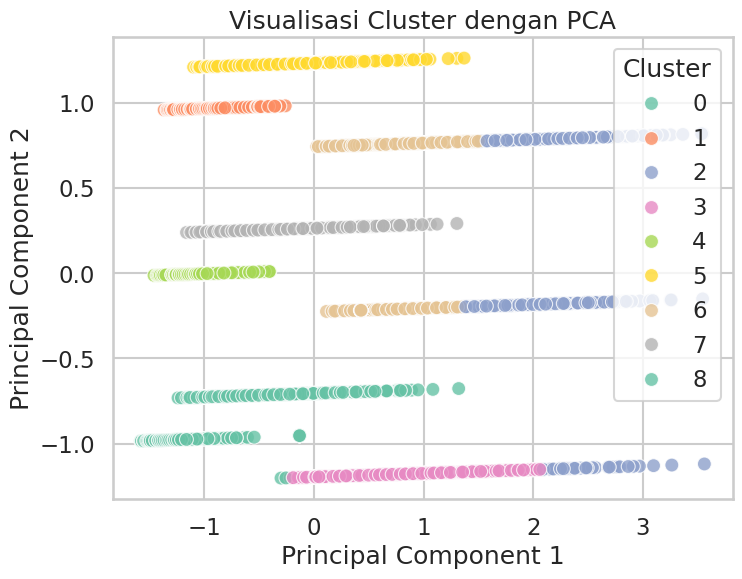

In [72]:
# Reduksi dimensi menggunakan PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)
df['PC1'] = components[:, 0]
df['PC2'] = components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df, palette='Set2', s=100, alpha=0.8)
plt.title("Visualisasi Cluster dengan PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()

Penjelasan:
- **PCA**: Mengurangi dimensi data agar dapat divisualisasikan dalam plot 2D.
- **Scatterplot**: Menampilkan distribusi cluster dan memudahkan interpretasi visual mengenai pemisahan antar cluster.

# Analisis Hasil

## 1. Inverse Transformasi Data
Jika data numerikal telah diskalakan, lakukan inverse transform untuk mendapatkan nilai asli.

In [73]:
df['gk_original'] = scaler.inverse_transform(df[['scaled_gk']])

## 2. Agregasi Data Berdasarkan Cluster

Lakukan agregasi untuk mengetahui statistik tiap cluster, seperti nilai minimum, maksimum, dan rata-rata untuk fitur numerikal serta modus untuk fitur kategorikal.

In [74]:
# Agregasi statistik untuk fitur numerikal: contoh pada 'gk_original'
cluster_agg_num = df.groupby('cluster')['gk_original'].agg(['min', 'max', 'mean']).reset_index()
print(cluster_agg_num)

# Fungsi untuk mendapatkan modus pada fitur kategorikal
def get_mode(series):
    return series.mode()[0]

# Agregasi untuk fitur kategorikal: 'jenis'
cluster_agg_cat = df.groupby('cluster')['jenis'].agg(get_mode).reset_index()
print(cluster_agg_cat)

   cluster       min       max           mean
0        0  190563.0  641806.0  334159.893987
1        1   52529.0  247232.0  133580.508929
2        2  469596.0  872843.0  580160.588119
3        3  207023.0  609733.0  390819.612526
4        4   53095.0  239224.0  117604.692857
5        5  181842.0  616790.0  338483.560714
6        6  215910.0  477801.0  365263.065074
7        7  187304.0  622068.0  338008.525000
8        8   48561.0  231037.0  101884.600733
   cluster       jenis
0        0     MAKANAN
1        1  NONMAKANAN
2        2       TOTAL
3        3       TOTAL
4        4  NONMAKANAN
5        5     MAKANAN
6        6       TOTAL
7        7     MAKANAN
8        8  NONMAKANAN


## Interpretasi
### Cluster 0
- **Garis Kemiskinan**: Min 190.563 | Max 641.806 | Rata-rata 334.159
- **Pengeluaran Dominan**: Makanan
- **Analisis**: Wilayah dengan tingkat kemiskinan sedang, fokus pada pengeluaran pangan menunjukkan prioritas utama adalah kebutuhan pokok.

### Cluster 1
- **Garis Kemiskinan**: Min 52.529 | Max 247.232 | Rata-rata 133.581
- **Pengeluaran Dominan**: Nonmakanan
- **Analisis**: Wilayah dengan kemiskinan rendah, pengeluaran lebih besar untuk kebutuhan nonpangan, kemungkinan biaya hidup lebih terjangkau.

### Cluster 2
- **Garis Kemiskinan**: Min 469.596 | Max 872.843 | Rata-rata 580.161
- **Pengeluaran Dominan**: Total (makanan dan nonmakanan)
- **Analisis**: Wilayah dengan kemiskinan tertinggi, pengeluaran merata mencerminkan biaya hidup tinggi atau daya beli lebih besar.

### Cluster 3
- **Garis Kemiskinan**: Min 207.023 | Max 609.733 | Rata-rata 390.820
- **Pengeluaran Dominan**: Total
- **Analisis**: Tingkat kemiskinan cukup tinggi, dengan pengeluaran seimbang antara pangan dan nonpangan.

### Cluster 4
- **Garis Kemiskinan**: Min 53.095 | Max 239.224 | Rata-rata 117.605
- **Pengeluaran Dominan**: Nonmakanan
- **Analisis**: Mirip Cluster 1, wilayah ini memiliki kemiskinan rendah dengan fokus pengeluaran nonpangan, kemungkinan biaya hidup rendah.

### Cluster 5
- **Garis Kemiskinan**: Min 181.842 | Max 616.790 | Rata-rata 338.484
- **Pengeluaran Dominan**: Makanan
- **Analisis**: Serupa dengan Cluster 0, wilayah ini memprioritaskan pengeluaran untuk kebutuhan pangan.

### Cluster 6
- **Garis Kemiskinan**: Min 215.910 | Max 477.801 | Rata-rata 365.263
- **Pengeluaran Dominan**: Total
- **Analisis**: Kemiskinan menengah ke atas, dengan pola pengeluaran seimbang antara pangan dan nonpangan.

### Cluster 7
- **Garis Kemiskinan**: Min 187.304 | Max 622.068 | Rata-rata 338.009
- **Pengeluaran Dominan**: Makanan
- **Analisis**: Seperti Cluster 0 dan 5, wilayah ini fokus pada pengeluaran pangan sebagai kebutuhan utama.

### Cluster 8
- **Garis Kemiskinan**: Min 48.561 | Max 231.037 | Rata-rata 101.885
- **Pengeluaran Dominan**: Nonmakanan
- **Analisis**: Wilayah dengan kemiskinan terendah, pengeluaran nonpangan dominan meskipun daya beli relatif rendah.

# Export data

In [75]:
df.to_csv("Dataset_cluster.csv", index=False)